In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
from imblearn.over_sampling import SMOTE

In [4]:
label = pd.read_csv('Data/Data_labeled.csv')

### 사출성형기 데이터셋 전처리

In [5]:
# 생산한 사출기 모델명 갯수 비교
label['EQUIP_NAME'].value_counts()

650톤-우진2호기    7992
1800TON-우진       2
650톤-우진          2
Name: EQUIP_NAME, dtype: int64

In [6]:
label = label.loc[label['EQUIP_NAME'] == "650톤-우진2호기"]

In [7]:
con_label = label
cn7_label = label.loc[(label['PART_NAME'] == "CN7 W/S SIDE MLD'G RH") | (label['PART_NAME'] == "CN7 W/S SIDE MLD'G LH")]
rg3_label = label.loc[(label['PART_NAME'] == "RG3 MOLD'G W/SHLD, RH") | (label['PART_NAME'] == "RG3 MOLD'G W/SHLD, LH")]

In [8]:
# 불필요 컬럼 제거
# Mold_Temp 값 0인것들 많음
drop_li = ['_id', 'TimeStamp', 'PART_FACT_PLAN_DATE', 'Reason', 'PART_FACT_SERIAL', 'PART_NAME', 'EQUIP_CD', 'EQUIP_NAME', 'Barrel_Temperature_7',
          'Switch_Over_Position', 'Mold_Temperature_1', 'Mold_Temperature_2','Mold_Temperature_5', 'Mold_Temperature_6', 'Mold_Temperature_7', 
           'Mold_Temperature_8', 'Mold_Temperature_9', 'Mold_Temperature_10', 'Mold_Temperature_11', 'Mold_Temperature_12']

In [9]:
con_label = con_label.drop(drop_li, axis = 1)
cn7_label = cn7_label.drop(drop_li, axis = 1)
rg3_label = rg3_label.drop(drop_li, axis = 1)

### 사출성형기 데이터셋 탐색적 데이터 분석

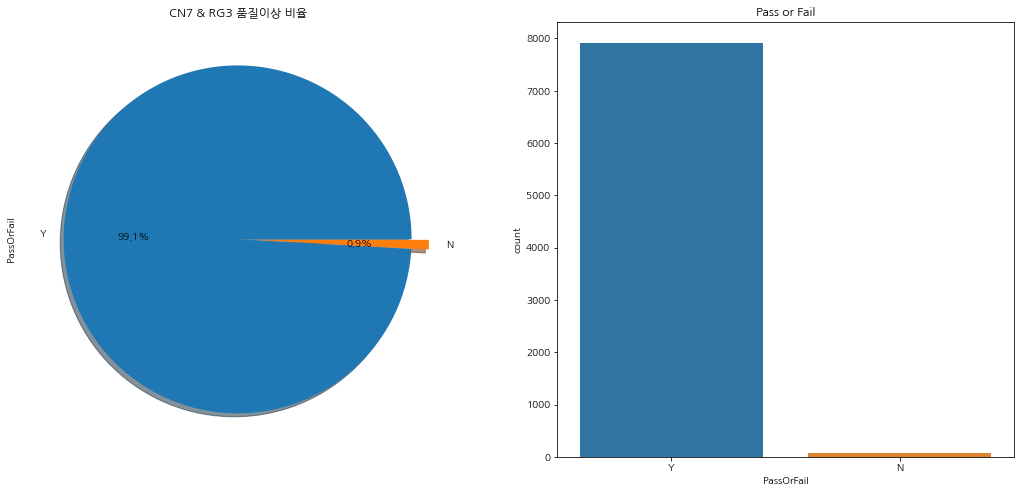

In [10]:
plt.rcParams["font.family"] = 'NanumGothic'

# CN7 & RG3 이상 데이터 비율 확인
f,ax=plt.subplots(1,2,figsize=(18,8))
con_label['PassOrFail'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('CN7 & RG3 품질이상 비율')
ax[0].set_ylabel('PassOrFail')

sns.countplot('PassOrFail',data=label,ax=ax[1])
ax[1].set_title('Pass or Fail')


plt.show()

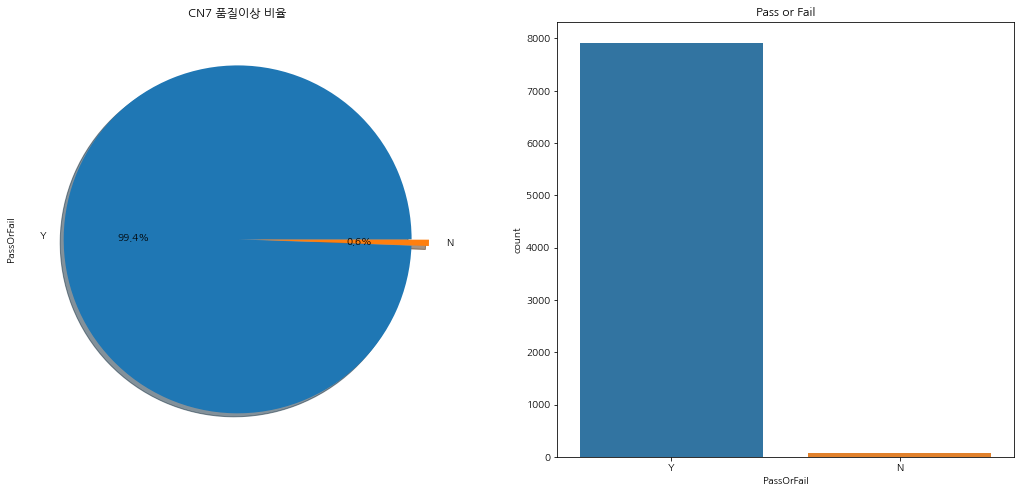

In [11]:
plt.rcParams["font.family"] = 'NanumGothic'

# CN7 이상 데이터 비율 확인
f,ax=plt.subplots(1,2,figsize=(18,8))
cn7_label['PassOrFail'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('CN7 품질이상 비율')
ax[0].set_ylabel('PassOrFail')

sns.countplot('PassOrFail',data=label,ax=ax[1])
ax[1].set_title('Pass or Fail')

plt.show()

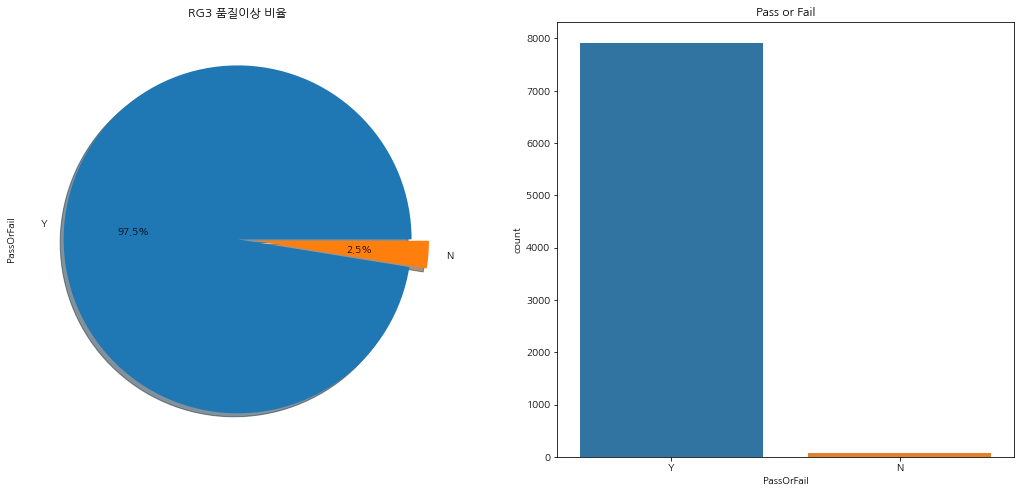

In [12]:
plt.rcParams["font.family"] = 'NanumGothic'

# RG3 이상 데이터 비율 확인
f,ax=plt.subplots(1,2,figsize=(18,8))
rg3_label['PassOrFail'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('RG3 품질이상 비율')
ax[0].set_ylabel('PassOrFail')

sns.countplot('PassOrFail',data=label,ax=ax[1])
ax[1].set_title('Pass or Fail')

plt.savefig('Test.png')
plt.show()

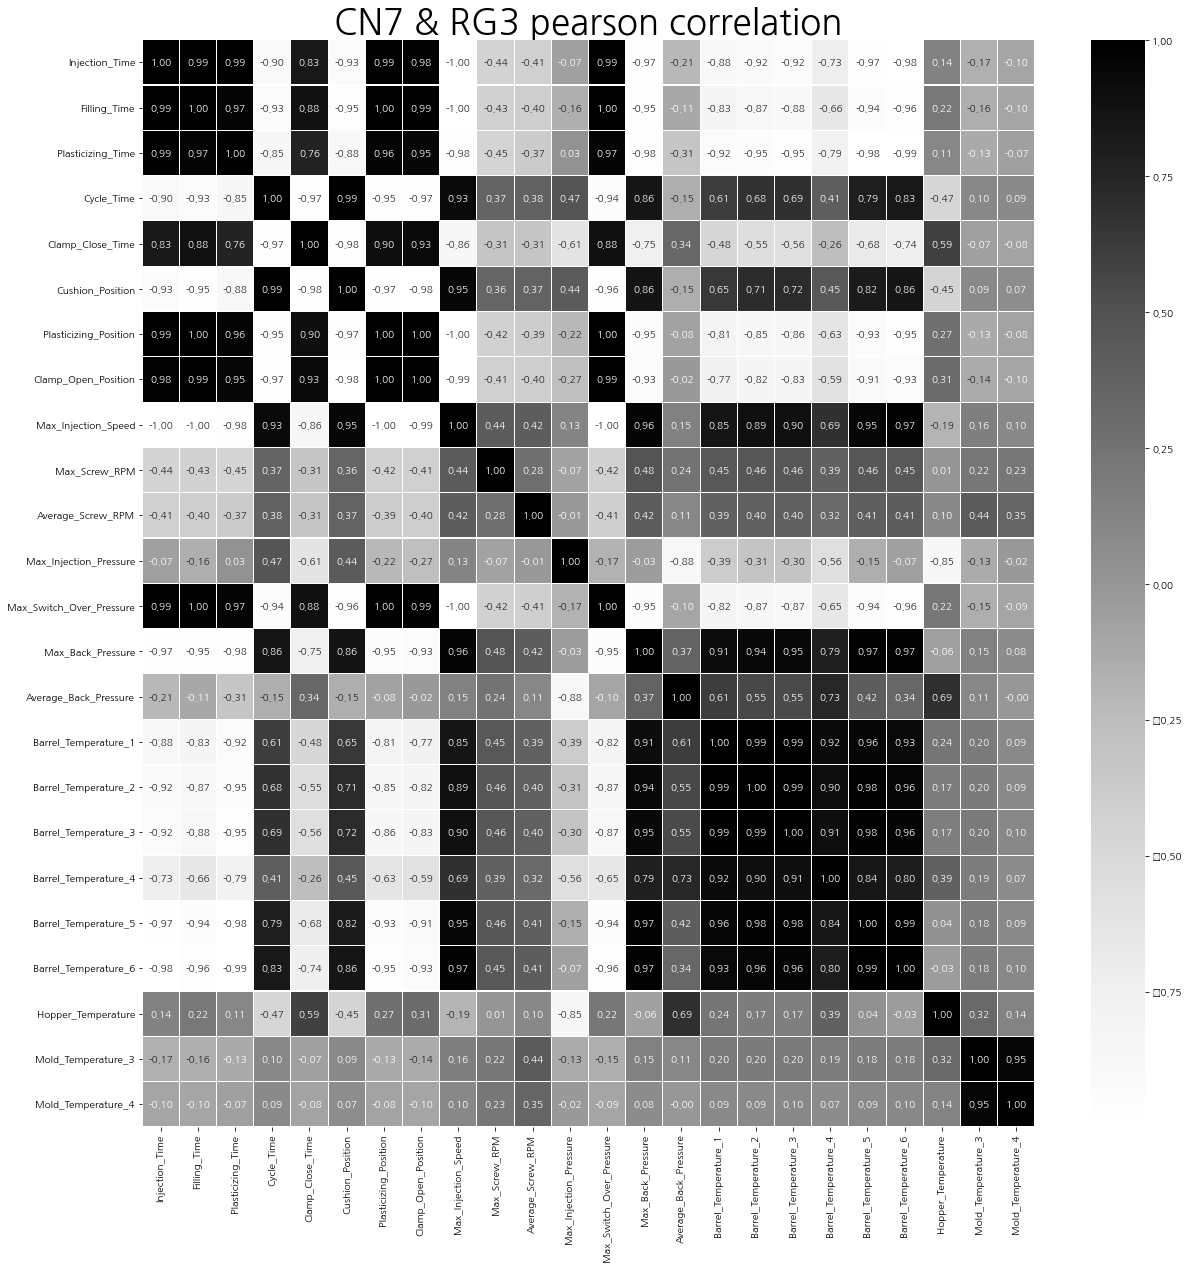

In [13]:
# 변수별 피어슨 유사도 계산 
plt.subplots(figsize = (20,20))
sns.heatmap(data = con_label.corr(), linewidths = 0.1, annot = True, fmt = '.2f', cmap = 'Greys')

parameters = {'axes.labelsize': 25,
          'axes.titlesize': 35}
plt.rcParams.update(parameters)

plt.title('CN7 & RG3 pearson correlation')
plt.show()

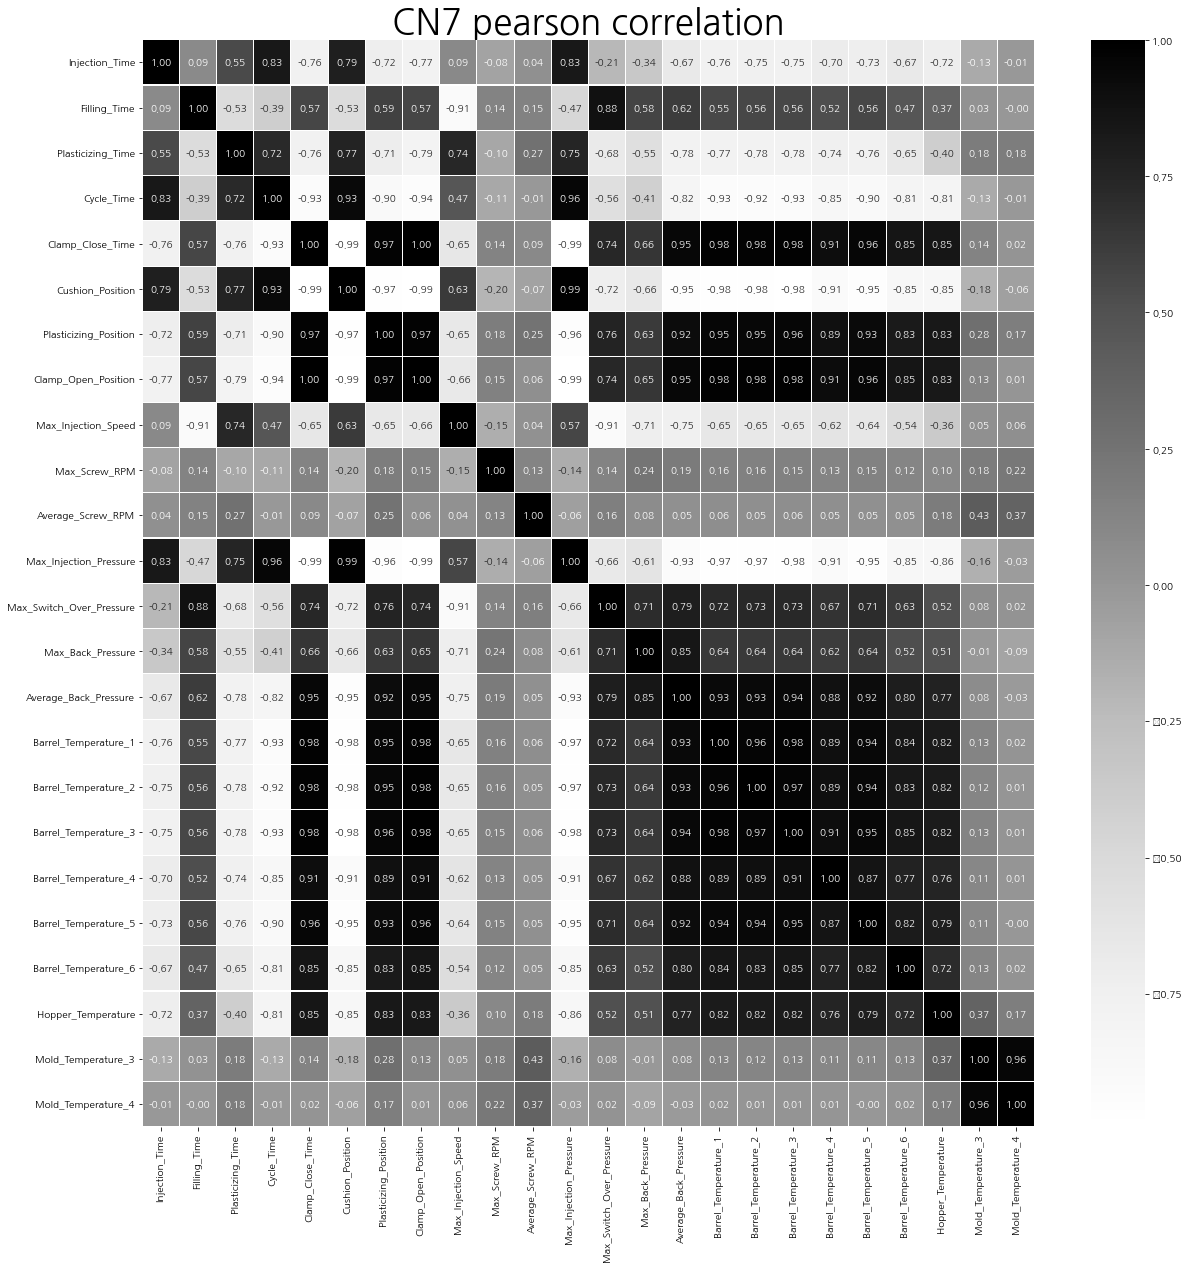

In [14]:
plt.subplots(figsize = (20,20))
sns.heatmap(data = cn7_label.corr(), linewidths = 0.1, annot = True, fmt = '.2f', cmap = 'Greys')

parameters = {'axes.labelsize': 25,
          'axes.titlesize': 35}
plt.rcParams.update(parameters)

plt.title('CN7 pearson correlation')
plt.show()

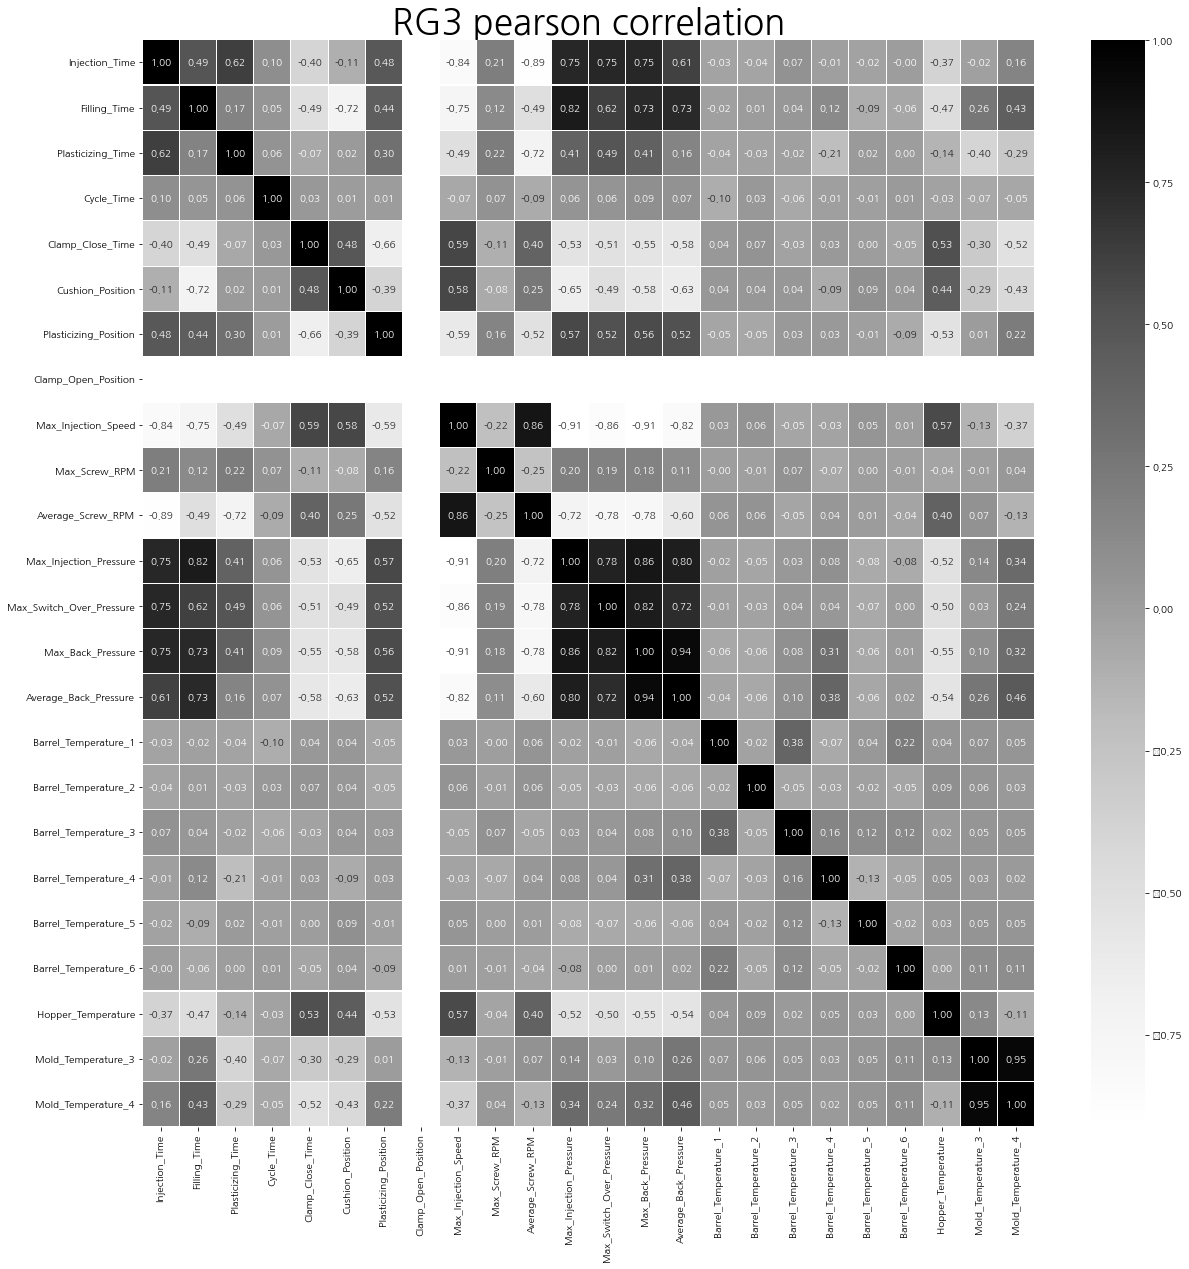

In [15]:
plt.subplots(figsize = (20,20))
sns.heatmap(data = rg3_label.corr(), linewidths = 0.1, annot = True, fmt = '.2f', cmap = 'Greys')

parameters = {'axes.labelsize': 25,
          'axes.titlesize': 35}
plt.rcParams.update(parameters)

plt.title('RG3 pearson correlation')
plt.show()

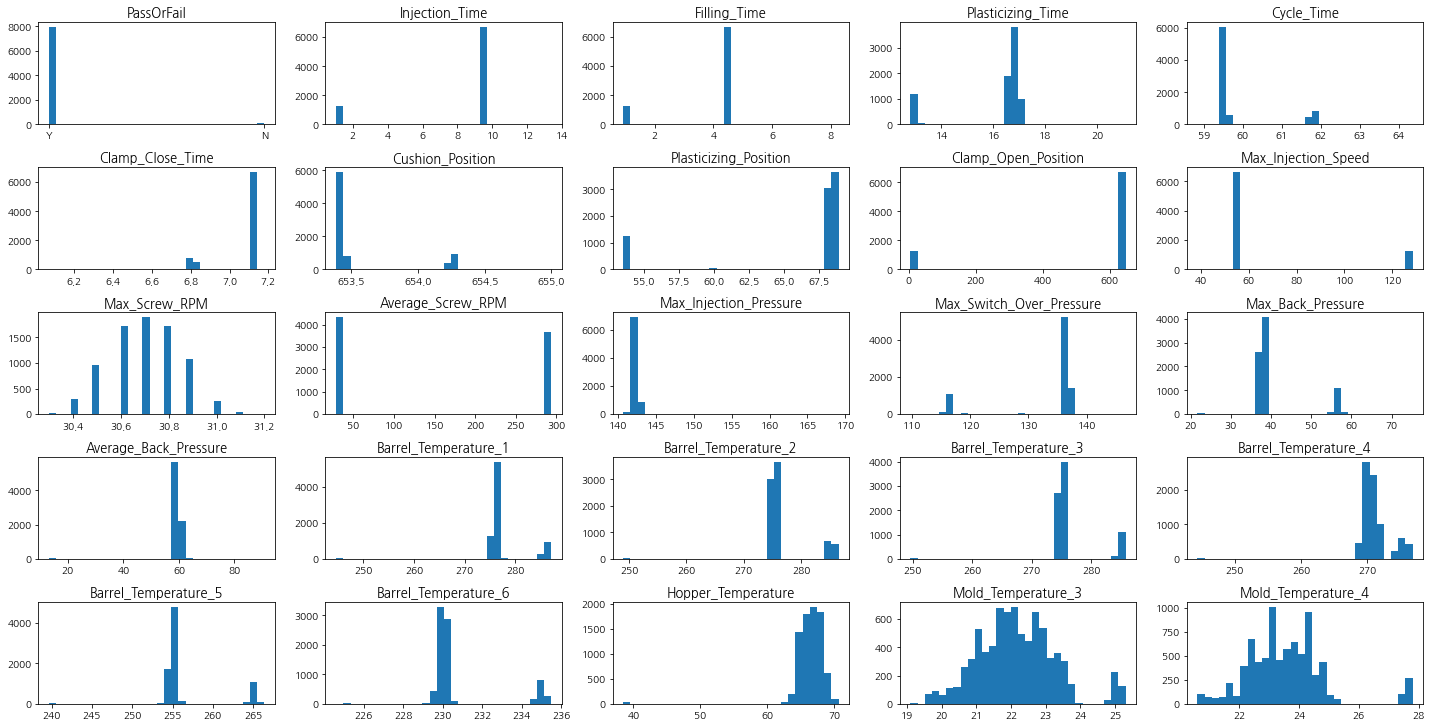

In [16]:
# 변수별 분포도 확인
parameters = {'axes.labelsize': 10,
          'axes.titlesize': 13}
plt.rcParams.update(parameters)

num_features = [col for col in con_label.columns]

n_cols = 5
n_rows = 6

fig = plt.gcf()
fig.set_size_inches(n_cols * 4, n_rows * 2)

for pos, feature in enumerate(num_features):
    sp = plt.subplot(n_rows, n_cols, pos + 1)
    plt.hist(con_label[feature], bins=30)
    plt.title(feature)
    
plt.tight_layout()
plt.show()

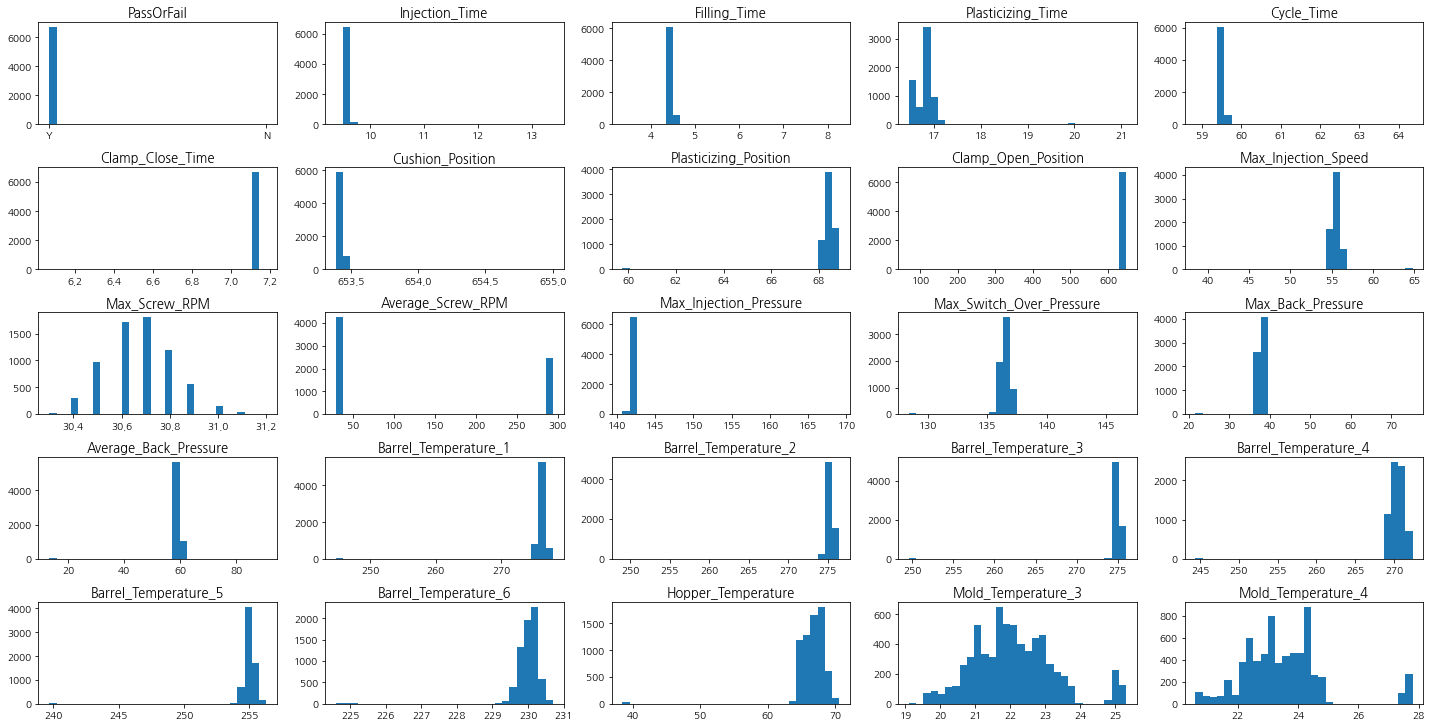

In [17]:
num_features = [col for col in cn7_label.columns]

n_cols = 5
n_rows = 6

fig = plt.gcf()
fig.set_size_inches(n_cols * 4, n_rows * 2)

for pos, feature in enumerate(num_features):
    sp = plt.subplot(n_rows, n_cols, pos + 1)
    plt.hist(cn7_label[feature], bins=30)
    plt.title(feature)
    
plt.tight_layout()
plt.show()

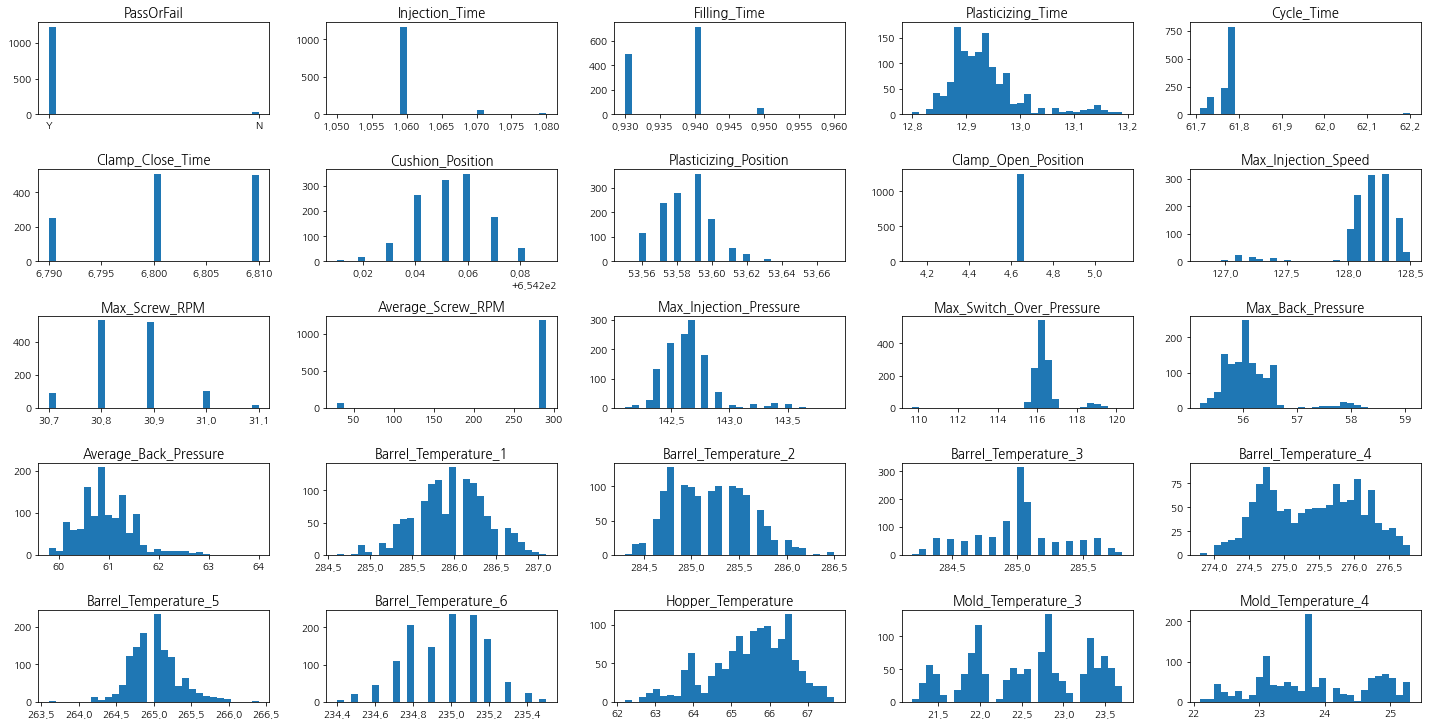

In [18]:
num_features = [col for col in rg3_label.columns]

n_cols = 5
n_rows = 6

fig = plt.gcf()
fig.set_size_inches(n_cols * 4, n_rows * 2)

for pos, feature in enumerate(num_features):
    sp = plt.subplot(n_rows, n_cols, pos + 1)
    plt.hist(rg3_label[feature], bins=30)
    plt.title(feature)
    
plt.tight_layout()
plt.show()

[0.65226373 0.17930063]


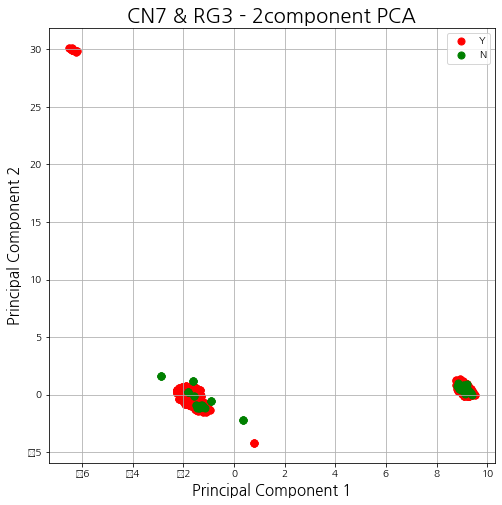

In [19]:
# PCA 시각화
scale = StandardScaler()

X = con_label.iloc[:, 1:]
Y = con_label.iloc[:, 0]

X = scale.fit_transform(X)

pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])

# 주성분1, 주성분2 설명력
print(pca.explained_variance_ratio_)

finalDF = pd.concat([principalDf.reset_index(drop = True), con_label[['PassOrFail']].reset_index(drop = True)], axis = 1)

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('CN7 & RG3 - 2component PCA', fontsize=20)

targets = ['Y', 'N']
colors = ['r', 'g']

for n, (target, color) in enumerate(zip(targets, colors)):
    indicesToKeep = finalDF['PassOrFail'] == target
    ax.scatter(finalDF.loc[indicesToKeep, 'principal component1']
           , finalDF.loc[indicesToKeep, 'principal component2']
           , c = color
           , s = 50)
ax.legend(targets)
ax.grid()

[0.66288989 0.10590223]


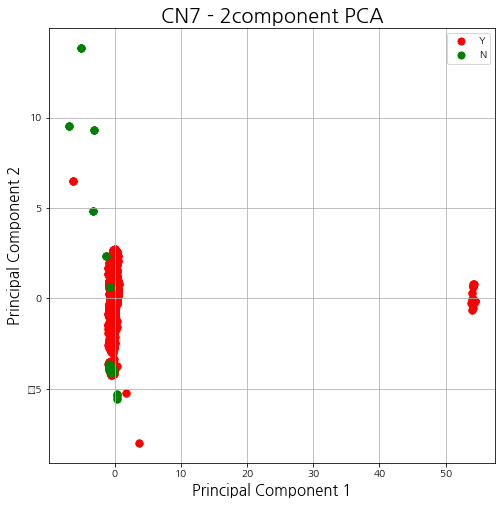

In [20]:
scale = StandardScaler()

X = cn7_label.iloc[:, 1:]
Y = cn7_label.iloc[:, 0]

X = scale.fit_transform(X)

pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])

# 주성분1, 주성분2 설명력
print(pca.explained_variance_ratio_)

finalDF = pd.concat([principalDf.reset_index(drop = True), cn7_label[['PassOrFail']].reset_index(drop = True)], axis = 1)

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('CN7 - 2component PCA', fontsize=20)

targets = ['Y', 'N']
colors = ['r', 'g']

for n, (target, color) in enumerate(zip(targets, colors)):
    indicesToKeep = finalDF['PassOrFail'] == target
    ax.scatter(finalDF.loc[indicesToKeep, 'principal component1']
           , finalDF.loc[indicesToKeep, 'principal component2']
           , c = color
           , s = 50)
ax.legend(targets)
ax.grid()

[0.36305804 0.11762366]


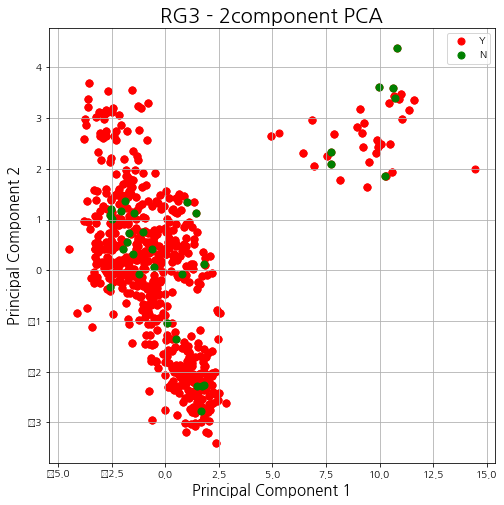

In [21]:
scale = StandardScaler()

X = rg3_label.iloc[:, 1:]
Y = rg3_label.iloc[:, 0]

X = scale.fit_transform(X)

pca = PCA(n_components=2)
printcipalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2'])

# 주성분1, 주성분2 설명력
print(pca.explained_variance_ratio_)

finalDF = pd.concat([principalDf.reset_index(drop = True), rg3_label[['PassOrFail']].reset_index(drop = True)], axis = 1)

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('RG3 - 2component PCA', fontsize=20)

targets = ['Y', 'N']
colors = ['r', 'g']

for n, (target, color) in enumerate(zip(targets, colors)):
    indicesToKeep = finalDF['PassOrFail'] == target
    ax.scatter(finalDF.loc[indicesToKeep, 'principal component1']
           , finalDF.loc[indicesToKeep, 'principal component2']
           , c = color
           , s = 50)
ax.legend(targets)
ax.grid()